# Midterm Project: Regularized Logistic Regression with Real Dataset

An extension of Logistic Regression with a real dataset

## Goals
    1. Upload and transform real valued dataset
    2. Scale the dataset using z-score normalization
    3. Implement regularization (extending compute_cose and compute_gradient functions)
    4. Plot the learning curve (cost vs iterations)

### Packages
First, we must import the required packages

In [1]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
import time

### The Dataset
This dataset is a dataset of diagnostic breast cancer data which includes 30 real values input features. These features encompass many medical attributes about each patient's tumor. Specifically, the 30 real valued features are computed from 10 attributes about each cell in the tumor. For each of the 10 attributes, the mean, standard error, and mean of the three largest values are recorded, resulting in 30 input features for our regression model. In addition to these features, each data point has an id number and a result, whether the tumor was malignant or benign.

Here we load this dataset:
  - `X_train` contains the 30 real valued input features
  - `y_train` is the diagnostic decision
      - `y_train = 1` if the patient's tumor was malignant 
      - `y_train = 0` if the patient's tumor was benign
  - Both `X_train` and `y_train` are numpy arrays.

In [2]:
def load_data(filename):
    data = np.loadtxt(filename, dtype=str, delimiter=',')

    X = data[:,2:].astype(np.float)
    y = [1 if item == 'M' else 0 for item in data[:,1]]

    return X, y

In [3]:
# load dataset

X_train, y_train = load_data("./data/wdbc.data")

### Notation
Here is a summary of some of the notation you will encounter, updated for multiple features.  

|General <img width=70/> <br />  Notation  <img width=70/> | Description<img width=350/>| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar, non bold                                                      ||
| $\mathbf{a}$ | vector, bold                                                 ||
| $\mathbf{A}$ | matrix, bold capital                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | training example maxtrix                  | `X_train` |   
|  $\mathbf{y}$  | training example  targets                | `y_train` 
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$Training Example | `X[i]`, `y[i]`|
| m | number of training examples | `m`|
| n | number of features in each example | `n`|
|  $\mathbf{w}$  |  parameter: weight,                       | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | The result of the model evaluation at $\mathbf{x^{(i)}}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` | 


### Normalization
Here we will use the z score normalization technique to normalize the dataset.

After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$


In [4]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return X_norm
 

In [5]:
# normalize the original features
X_norm = zscore_normalize_features(X_train)

### Regularization
Here we will extend the compute cost and compute gradient functions to utilize regularization techniques to avoid overfitting.

Cost function and regression function for Regularized Logistic Regression:
$$
\begin{aligned}
&J(\vec{w}, b)=-\frac{1}{m} \sum_{i=1}^m\left[y^{(i)} \log \left(f_{\vec{w}, b}\left(\vec{x}^{(i)}\right)\right)+\left(1-y^{(i)}\right) \log \left(1-f_{\vec{w}, b}\left(\vec{x}^{(i)}\right)\right)\right]+\frac{\lambda}{2 m} \sum_{j=1}^n w_j^2\\
&\text { repeat }\{\\
&w_j=w_j-\alpha\left[\frac{1}{m} \sum_{i=1}^m\left[\left(f_{\vec{w}, b}\left(\vec{x}^{(i)}\right)-y^{(i)}\right) x_j^i\right]+\frac{\lambda}{m} w_j\right]\\
&b=b-\alpha\left[\frac{1}{m} \sum_{i=1}^m\left(f_{\vec{w}, b}\left(\vec{x}^{(i)}\right)-y^{(i)}\right)\right]\\
&\}\\
&\text { Where } f_{\vec{w}, b}(\vec{x})=\frac{1}{1+e^{-(\vec{w} \cdot \vec{x}+b)}}
\end{aligned}
$$

In [6]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
    g = (1/(1+np.exp(-z)))
    return g

def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: scalar value for regularization
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape

    total_cost = ((-1/m)*sum_losses(X, y, w, b, m))+((lambda_/(2*m))*sum_of_squared_features(w, n))
    
    
    return total_cost

def sum_of_squared_features(w, n):
    return sum([w[j]**2 for j in range(n)])


def sum_losses(X, y, w, b, m):
    return sum([loss(sigmoid(np.dot(w, X[i])+b), y[i]) for i in range(m)])


def loss(fwbx, y):
    return (y*np.log(fwbx)) + (1-y)*np.log(1-fwbx)

### Gradient Descent
Here we calculate the gradient for logistic regression with regularization and use it to calculate the gradient descent to learn theta.

In [7]:
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: scalar value for regularization
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    dj_db = (1/m)*sum([sigmoid(np.dot(X[i], w)+b)-y[i] for i in range(m)])
    
    dj_dw = (1/m)*sum([(sigmoid(np.dot(X[i], w)+b)-y[i])*X[i] for i in range(m)])+ ((lambda_/m)*w)

    
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha*dj_dw               
        b_in = b_in - alpha*dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

### Training
Here we run gradient descent for our model with some parameters we can experiment with to get the best results. A larger alpha means that the weights and biases are modified more at every step. A larger lambda means more regulization is done.

In [8]:
# initialize parameters
initial_w = np.zeros((X_norm.shape[1]))
initial_b = 0.
# some gradient descent settings
iterations = 10000
alpha = 1.0e-3
lambda_ = 5
# run gradient descent 
w_final, b_final, J_hist, W_hist = gradient_descent(X_norm, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations, lambda_)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_norm[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost     0.69   
Iteration 1000: Cost     0.25   
Iteration 2000: Cost     0.19   
Iteration 3000: Cost     0.16   
Iteration 4000: Cost     0.15   
Iteration 5000: Cost     0.14   
Iteration 6000: Cost     0.13   
Iteration 7000: Cost     0.13   
Iteration 8000: Cost     0.12   
Iteration 9000: Cost     0.12   
Iteration 9999: Cost     0.12   
b,w found by gradient descent: -0.33,[ 0.36871781  0.32313821  0.36511082  0.36364845  0.13722045  0.13426724
  0.28130855  0.37135542  0.10100307 -0.1566099   0.32108198  0.00231499
  0.27656912  0.29478144 -0.00445448 -0.08629911 -0.07214296  0.06094345
 -0.06199763 -0.16763157  0.43350334  0.39224404  0.41734921  0.40814405
  0.29043102  0.2011423   0.27759468  0.3924805   0.26841951  0.0987233 ] 
prediction: 9.79, target value: 1
prediction: 4.52, target value: 1
prediction: 7.53, target value: 1
prediction: 4.59, target value: 1
prediction: 4.65, target value: 1
prediction: 1.32, target value: 1
prediction: 4.44, target valu

### Evaluation
Here we measure both the accuracy of our model and the cost over the gradient descent iterations, so we can see how much it learned per iteration, as well as how accurate it is in the end.

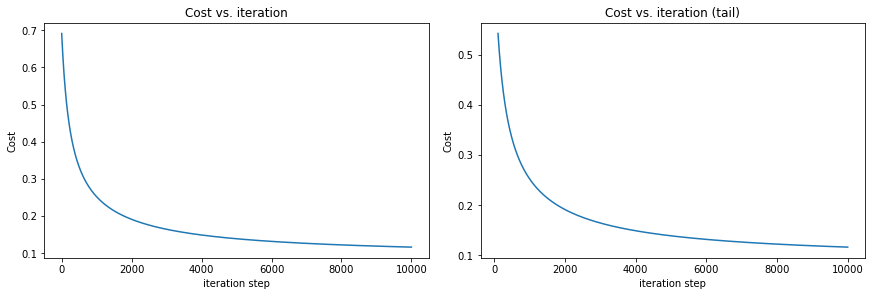

In [9]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [10]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    p = np.asarray([1 if sigmoid(np.dot(X[i], w)+b) >= 0.5 else 0 for i in range(m)])
    return p

In [11]:
p = predict(X_norm, w_final,b_final)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 98.066784
